# Improving Employee Retention by Predicting Employee Attrition Using Machine Learning

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import waterfall_chart as wfall

from matplotlib import pyplot as plt
from matplotlib import rcParams

pd.options.display.max_columns = None

custom_rc = {'figure.figsize': (12,8),
             'axes.labelsize': 14,
             'figure.titlesize': 18}
rcParams.update(custom_rc)

In [2]:
plt.style.use('ggplot')

## About This Dataset

[This](https://docs.google.com/spreadsheets/d/1EQlE-TUc06O1-HBRP-siI3ZV_4g48-68/edit?rtpof=true) dataset is provided by Rakamin Academy. Based on quick google search, this dataset is adapted from [Human Resource Data Set](https://www.kaggle.com/datasets/rhuebner/human-resources-data-set?select=HRDataset_v14.csv) on Kaggle complying to their license. Other than the columns' names being translated, there are some columns added and some being removed.

In this project, a company dealing with high attrition rate needs to take a data-driven decision. For that, I'm tasked to help solve that problem starting from making inferential analysis to making machine learning model to make recommendations.

In [3]:
filepath = "Improving Employee Retention by Predicting Employee Attrition Using Machine Learning.csv"
df_raw = pd.read_csv(filepath)
df = df_raw.copy()
df.head()

,Username,EnterpriseID,StatusPernikahan,JenisKelamin,StatusKepegawaian,Pekerjaan,JenjangKarir,PerformancePegawai,AsalDaerah,HiringPlatform,SkorSurveyEngagement,SkorKepuasanPegawai,JumlahKeikutsertaanProjek,JumlahKeterlambatanSebulanTerakhir,JumlahKetidakhadiran,NomorHP,Email,TingkatPendidikan,PernahBekerja,IkutProgramLOP,AlasanResign,TanggalLahir,TanggalHiring,TanggalPenilaianKaryawan,TanggalResign
0,spiritedPorpoise3,111065,Belum_menikah,Pria,Outsource,Software Engineer (Back End),Freshgraduate_program,Sangat_bagus,Jakarta Timur,Employee_Referral,4,4.0,0.0,0.0,9.0,+6282232522xxx,spiritedPorpoise3135@yahoo.com,Magister,1,1.0,masih_bekerja,1972-07-01,2011-01-10,2016-2-15,-
1,jealousGelding2,106080,Belum_menikah,Pria,FullTime,Data Analyst,Freshgraduate_program,Sangat_kurang,Jakarta Utara,Website,4,4.0,4.0,0.0,3.0,+6281270745xxx,jealousGelding2239@yahoo.com,Sarjana,1,1.0,toxic_culture,1984-04-26,2014-01-06,2020-1-17,2018-6-16
2,pluckyMuesli3,106452,Menikah,Pria,FullTime,Software Engineer (Front End),Freshgraduate_program,Bagus,Jakarta Timur,Indeed,4,3.0,0.0,0.0,11.0,+6281346215xxx,pluckyMuesli3961@icloud.com,Magister,1,1.0,jam_kerja,1974-01-07,2011-01-10,2016-01-10,2014-9-24
3,stressedTruffle1,106325,Belum_menikah,Pria,Outsource,Software Engineer (Front End),Freshgraduate_program,Bagus,Jakarta Pusat,LinkedIn,3,3.0,0.0,4.0,6.0,+6283233846xxx,stressedTruffle1406@hotmail.com,Sarjana,1,0.0,masih_bekerja,1979-11-24,2014-2-17,2020-02-04,-
4,shyTermite7,111171,Belum_menikah,Wanita,FullTime,Product Manager,Freshgraduate_program,Bagus,Jakarta Timur,LinkedIn,3,3.0,0.0,0.0,11.0,+6287883263xxx,shyTermite7149@gmail.com,Sarjana,1,0.0,ganti_karir,1974-11-07,2013-11-11,2020-1-22,2018-09-06


## Data Overview

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 287 entries, 0 to 286
Data columns (total 25 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Username                            287 non-null    object 
 1   EnterpriseID                        287 non-null    int64  
 2   StatusPernikahan                    287 non-null    object 
 3   JenisKelamin                        287 non-null    object 
 4   StatusKepegawaian                   287 non-null    object 
 5   Pekerjaan                           287 non-null    object 
 6   JenjangKarir                        287 non-null    object 
 7   PerformancePegawai                  287 non-null    object 
 8   AsalDaerah                          287 non-null    object 
 9   HiringPlatform                      287 non-null    object 
 10  SkorSurveyEngagement                287 non-null    int64  
 11  SkorKepuasanPegawai                 282 non-n

Most of the features in the dataset are self explanatory, however I will still cross-reference with the source dataset description. The columns' descriptions are as follows:
- **Username**: Employee's username
- **EnterpriseID**: Employee's unique id
- **StatusPernikahan**: Employee's marital status
- **JenisKelamin**: Employee's gender
- **StatusKepegawaian**: Employee's employment status
- **Pekerjaan**: Employee's job position
- **JenjangKarir**: Which career progression the employee is in
- **PerformancePegawai**: Employee's performance score notated in 5 ordinal scores
- **AsalDaerah**: Employee's city of origin
- **HiringPlatform**: What platform was used to hire the employee
- **SkorSurveyEngagement**: Employee's engagement towards company on scale 1-5
- **SkorKepuasanPegawai**: Employee's satisfaction towards company on scale 1-5
- **JumlahKeikutsertaanProjek**: Number of times the employee participated in projects
- **JumlahKeterlambatanSebulanTerakhir**: Employee's tardiness in the last 1 month
- **JumlahKetidakhadiran**: Number of times the employee is absent
- **NomorHP**: Employee's phone number
- **Email**: Employee's email address
- **TingkatPendidikan**: Employee's last education level
- **PernahBekerja**: Denotes whether the employee has worked previously or not
- **IkutProgramLOP**: Denotes whether the employee has joined *Laptop Ownership Program* or not
- **AlasanResign**: Employee's reason for resigning if they do resign
- **TanggalLahir**: Employee's date of birth
- **TanggalHiring**: Employee's date of hiring
- **TanggalPenilaianKaryawan**: Employee's date of last performance review
- **TanggalResign**: Employee's date of resignation

## EDA
I will start with some quick Analysis to understand the dataset better. Let's separate the columns into groups based on their types of data.

In [5]:
identifier = ['Username', 'EnterpriseID', 'NomorHP', 'Email']
date_col = ['TanggalLahir', 'TanggalHiring', 'TanggalPenilaianKaryawan', 'TanggalResign']
nums = ['JumlahKeikutsertaanProjek', 'JumlahKeterlambatanSebulanTerakhir', 'JumlahKetidakhadiran']
cats = df.drop(identifier + date_col + nums, axis=1).columns

### Descriptive Analysis

In [6]:
df[identifier].astype('object').describe().T

,count,unique,top,freq
Username,287,285,boredEggs0,2
EnterpriseID,287,287,111065,1
NomorHP,287,287,+6282232522xxx,1
Email,287,287,spiritedPorpoise3135@yahoo.com,1


For some reason, there is duplicated **Username** found. However, everything else are unique as expected, which means there is no need to check for duplicated rows in this dataset.

In [7]:
df[nums].describe().T

,count,mean,std,min,25%,50%,75%,max
JumlahKeikutsertaanProjek,284.0,1.179577,2.294441,0.0,0.0,0.0,0.0,8.0
JumlahKeterlambatanSebulanTerakhir,286.0,0.412587,1.275016,0.0,0.0,0.0,0.0,6.0
JumlahKetidakhadiran,281.0,10.448399,6.902252,1.0,5.0,10.0,15.0,55.0


In [8]:
df[cats].astype('object').describe().T

,count,unique,top,freq
StatusPernikahan,287,5,Belum_menikah,132
JenisKelamin,287,2,Wanita,167
StatusKepegawaian,287,3,FullTime,217
Pekerjaan,287,14,Software Engineer (Back End),109
JenjangKarir,287,3,Freshgraduate_program,169
PerformancePegawai,287,5,Biasa,85
AsalDaerah,287,5,Jakarta Pusat,72
HiringPlatform,287,9,Indeed,85
SkorSurveyEngagement,287,5,3,132
SkorKepuasanPegawai,282.0,5.0,3.0,96.0


In [9]:
df[date_col].describe().T

,count,unique,top,freq
TanggalLahir,287,284,1987-06-14,2
TanggalHiring,287,97,2011-01-10,12
TanggalPenilaianKaryawan,287,127,2020-1-14,17
TanggalResign,287,53,-,198


### Checking Features' Values

In [10]:
na_col = []
print('Unique values on non-date features:')
for col in df.drop(date_col + identifier, axis=1).columns:
    if df[col].isna().any():
        na_col.append(col)
    print(f'{col}:')
    print(f'\t{df[col].unique()}\n')

Unique values on non-date features:
StatusPernikahan:
	['Belum_menikah' 'Menikah' 'Bercerai' 'Lainnya' '-']

JenisKelamin:
	['Pria' 'Wanita']

StatusKepegawaian:
	['Outsource' 'FullTime' 'Internship']

Pekerjaan:
	['Software Engineer (Back End)' 'Data Analyst'
 'Software Engineer (Front End)' 'Product Manager'
 'Software Engineer (Android)' 'Scrum Master'
 'Product Design (UX Researcher)' 'Product Design (UI & UX)'
 'Digital Product Manager' 'Data Engineer' 'Software Engineer (iOS)'
 'DevOps Engineer' 'Software Architect' 'Machine Learning Engineer']

JenjangKarir:
	['Freshgraduate_program' 'Senior_level' 'Mid_level']

PerformancePegawai:
	['Sangat_bagus' 'Sangat_kurang' 'Bagus' 'Biasa' 'Kurang']

AsalDaerah:
	['Jakarta Timur' 'Jakarta Utara' 'Jakarta Pusat' 'Jakarta Selatan'
 'Jakarta Barat']

HiringPlatform:
	['Employee_Referral' 'Website' 'Indeed' 'LinkedIn' 'CareerBuilder'
 'Diversity_Job_Fair' 'Google_Search' 'On-line_Web_application' 'Other']

SkorSurveyEngagement:
	[4 3 2 1 5]



In [11]:
print('Columns with missing values:')
for col in na_col:
    print(f'* {col}')

Columns with missing values:
* SkorKepuasanPegawai
* JumlahKeikutsertaanProjek
* JumlahKeterlambatanSebulanTerakhir
* JumlahKetidakhadiran
* IkutProgramLOP
* AlasanResign


Based on observation from descriptive analysis, here are the method in handling missing values on those columns:
- **SkorKepuasanPegawai** will be filled with mode, indicating their employment satisfaction to be average
- **JumlahKeikutsertaanProjek** will be filled with 0, indicating they haven't participate in any projects
- **JumlahKeterlambatanSebulanTerakhir** will be filled with 0, indicating they haven't been tardy in the last month
- **JumlahKetidakhadiran** will be filled with 0, indicating they haven't been absent
- **IkutProgramLOP** will be filled with 0, indicating they don't participate in LOP program
- **AlasanResign** will be filled with 'masih_bekerja', indicating they are still working in the company

Aside from 6 columns having missing values, there are some columns with questionable values such as:
- In **StatusPernikahan**, there is a value of '-' which might indicates single status, however it's unclear so it should be combined into 'Lainnya' or 'Others' value
- In **PernahBekerja**, there are only value of 1 and 'yes' which means after changing 'yes' to 1, this column will have singular value and need to be dropped
- In **AlasanResign**, there is a value 'Product Design (UI & UX)' which is not clear in the context of resigning reason, however let's leave this be for now

## Data Preprocessing

### Handling Missing Values

Missing values will be handled according to previous analysis.

In [12]:
df['SkorKepuasanPegawai'].fillna(df.SkorKepuasanPegawai.mode()[0], inplace=True)
fill_zero = ['JumlahKeikutsertaanProjek', 'JumlahKeterlambatanSebulanTerakhir', 'JumlahKetidakhadiran', 'IkutProgramLOP']
for col in fill_zero:
    df[col].fillna(0, inplace=True)
df['AlasanResign'].fillna('masih_bekerja', inplace=True)

### Cleaning Columns' Values and Datatypes

This part includes handling **StatusPernikahan** and **PernahBekerja** according to previous analysis. On top of that, to standardize the format for **TanggalResign**, the value '-' will be changed into an arbitrary date of '2100-1-1' to indicate employees who are still working.

In [13]:
df['StatusPernikahan'].replace('-', 'Lainnya', inplace=True)
df['PernahBekerja'].replace('yes', '1', inplace=True)
df['TanggalResign'].replace('-', '2100-1-1', inplace=True)
df.PernahBekerja.value_counts()

1    287
Name: PernahBekerja, dtype: int64

As expected previously, **PernahBekerja** column does indeed have singular value, thus it will be dropped.

In [14]:
# Standardize ordinal columns to int64 datatypes
float_col = df.select_dtypes('float')
df[float_col.columns] = float_col.astype('int64')

# Change datatype of date columns into datetime
df[date_col] = df.apply(lambda x: pd.to_datetime(x[date_col], 
                format='%Y-%m-%d', errors='ignore'), axis=1)

# Drop identifier columns and PernahBekerja
df.drop(identifier, axis=1, inplace=True)
df.drop('PernahBekerja', axis=1, inplace=True)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 287 entries, 0 to 286
Data columns (total 20 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   StatusPernikahan                    287 non-null    object        
 1   JenisKelamin                        287 non-null    object        
 2   StatusKepegawaian                   287 non-null    object        
 3   Pekerjaan                           287 non-null    object        
 4   JenjangKarir                        287 non-null    object        
 5   PerformancePegawai                  287 non-null    object        
 6   AsalDaerah                          287 non-null    object        
 7   HiringPlatform                      287 non-null    object        
 8   SkorSurveyEngagement                287 non-null    int64         
 9   SkorKepuasanPegawai                 287 non-null    int64         
 10  JumlahKeikutsertaanProjek 

## Annual Report on Employee Number Changes

After the data is cleaned, the next task will be to analyze the employment's health by checking on employee number changes. In this task, some feature extraction might be needed to visualize the data better. Employee number changes will be analyzed by calculating total employees every year to see the changes due to hiring and resigning of employees. The company's employment is healthy when they can get more employees hired compared to employees resigning.

In [21]:
emp_dates = df[['TanggalHiring', 'TanggalResign']].copy()

emp_dates['TahunHiring'] = emp_dates['TanggalHiring'].dt.year
emp_dates['TahunResign'] = emp_dates['TanggalResign'].dt.year

emp_dates.head(5)

,TanggalHiring,TanggalResign,TahunHiring,TahunResign
0,2011-01-10,2100-01-01,2011,2100
1,2014-01-06,2018-06-16,2014,2018
2,2011-01-10,2014-09-24,2011,2014
3,2014-02-17,2100-01-01,2014,2100
4,2013-11-11,2018-09-06,2013,2018


In [50]:
# Count total employees hired per year
hired = emp_dates.groupby('TahunHiring')[['TanggalHiring']].count().reset_index()
hired.columns = ['Year', 'Hired']

# Count total employees resigned per year
resign = emp_dates.groupby('TahunResign')[['TanggalHiring']].count().reset_index()
resign.columns = ['Year', 'Resigned']

# Left join both dataframe
emp_changes = pd.merge(hired, resign, how='outer', on='Year')

Since year '2100' is the arbitrary number to indicate employees who are still working, that row will be dropped. The missing values for this dataframe will then be filled with 0 to indicate no change.

In [51]:
emp_changes.drop(emp_changes[emp_changes.Year == 2100].index, inplace=True)
emp_changes.fillna(0, inplace=True)
emp_changes = emp_changes.astype('int64')

In [76]:
emp_changes['EmpGrowth'] = emp_changes['Hired'] - emp_changes['Resigned']
emp_changes.head(3)

,Year,Hired,Resigned,EmpGrowth
0,2006,1,0,1
1,2007,2,0,2
2,2008,2,0,2


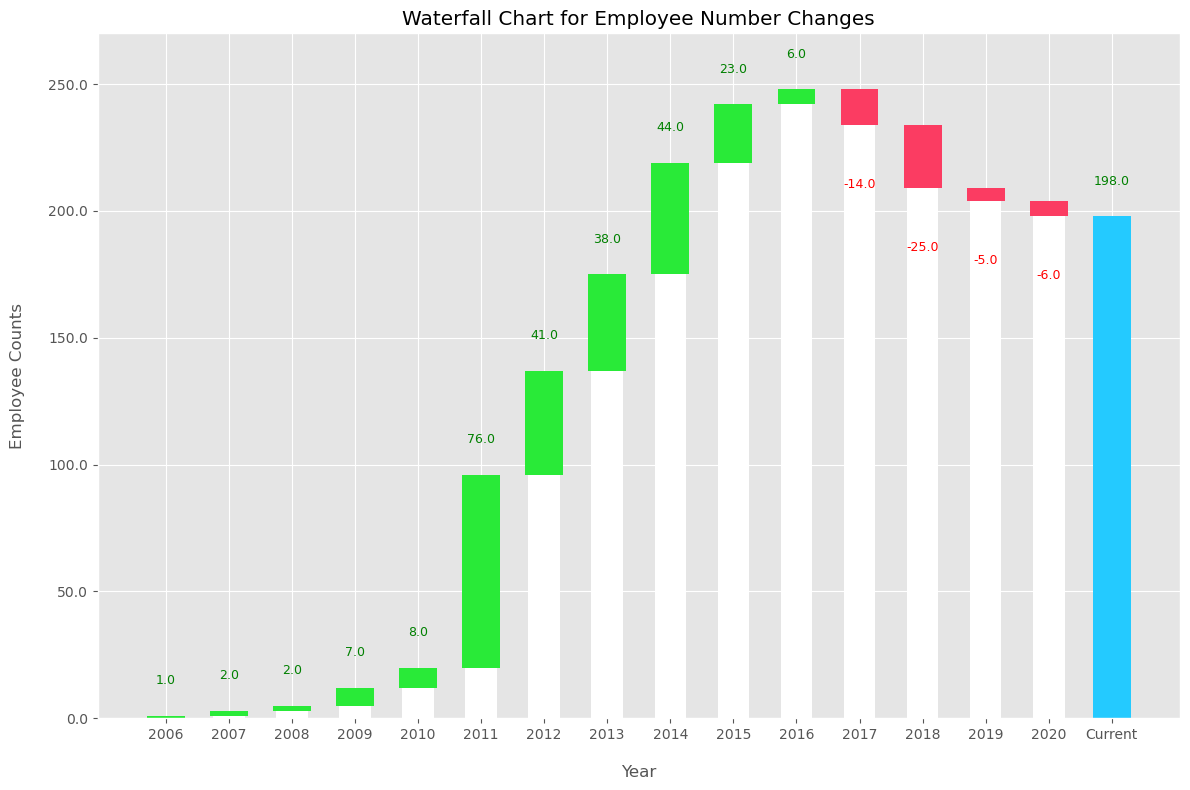

In [74]:
wfall.plot(emp_changes['Year'].astype('str'), 
           emp_changes['EmpGrowth'],
           rotation_value=0,
           net_label='Current',
           Title='Waterfall Chart for Employee Number Changes',
           y_lab='Employee Counts',
           x_lab='Year',)
plt.ylim(0, 270)
plt.show()

In [88]:
# Employee count before 2018
bef18 = emp_changes[emp_changes.Year < 2018]['EmpGrowth'].sum()

# Employee count before 2019
aft18 = emp_changes[emp_changes.Year < 2019]['EmpGrowth'].sum()

# Count difference
left18 = abs(aft18 - bef18)

# Calulating biggest turn over at 2018
turn_over_rate = left18 * 100 / ((aft18 + bef18) / 2)
print(f'Year 2018 turnover rate: {turn_over_rate:.2f}%')

Year 2018 turnover rate: 11.29%


Based on the graph above, the company actually has healthy employment status. There was a good upward trend on employment rate starting on year 2011 that slowed down on 2016. Employment rate going down after that until current time, however turnover rate seems to be tolerable at a glance. Worst turnover can be observed at year 2018 with 11.29% turn over rate that's higher than 10% (according to general rule of thumbs). Unfortunately, I only have data of year 2022 for [industry average turnover rate](https://www.linkedin.com/business/talent/blog/talent-strategy/industries-with-the-highest-turnover-rates#:~:text=compared%20with%20the%20overall%20average%20of%2010.6%25) to compare.

The upward trend on employment rate might be attributed to the growing amount of data worldwide benefiting tech companies. This growing amount of data shows an upward trend from 2010 to 2020 according to [Nasdaq](https://www.nasdaq.com/articles/a-decade-of-change%3A-how-tech-evolved-in-the-2010s-and-whats-in-store-for-the-2020s#:~:text=AI%20and%20Big%20Data%20Took%20Off). The slowing down of employment rate on 2015 and 2016 might be attributed to the company's [resource maturity](https://www.upwork.com/resources/stages-of-business-growth#resource-maturity:~:text=After%20a%20successful%20take%2Doff%20where%20the%20company%20has%20achieved%20the%20rapid%20growth%20it%20aimed%20for%2C%20the%20main%20concern%20of%20businesses%20entering%20the%20resource%20maturity%20stage%20is%20proper%20management%20of%20the%20financial%20gains%20from%20the%20last%20phase).

The downward trend on year 2017 might be attributed to change in world economy. This change opens up more job opportunities that leads to trend in switching jobs according to [CNN](https://money.cnn.com/2017/12/28/news/economy/jobs-2017/index.html#:~:text=Another%20sign%20of,plenty%20of%20options.).